# Real-Time Seizure Classification Model

#### Imports

##### Import libraries

In [1]:
''' Import libraries'''
# Built-in Python libraries
import os

# Custom Functions
from feature_extraction import *
from log_reg_funcs import *

# 3rd-Party Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
import seaborn as sns
# from seaborn import heatmap
# from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf


##### Import dataset

In [2]:
'''Import dataset'''
filename = 'datasets/dataset_all_filt.csv'
dataset = pd.read_csv(filename) # Preprocessed EEG Dataset

state = dataset['state'].to_numpy() # Correct labels for each time segment
filename = dataset['filename'].to_list() # filename for each sample
data = dataset.drop(columns=['state', 'filename']) # Voltage [uV]

fs = 256 # Sampling Frequency [Hz]

channels = data.keys().to_list()
num_channels = len(channels)
class_labels = {0:'Not Seizure', 1:'Seizure'} # classes to be predicted for each time segment

#### Feature Extraction

In [7]:
num_features = 9
num_segments = int( len(data) / fs ) # number of 1-second time windows
time = np.arange(num_segments, dtype=int)

# Create np array with shape (num_segments, num_channels, num_features) 
x_data = np.zeros(
    shape=(
        num_channels,
        num_segments,
        num_features
    ), dtype=np.float64)
print(x_data.shape)

# Perform feature extraction for each time segment across all channels
for ch_num, ch in enumerate(channels):
    for t in time:
        start_idx = t * fs
        end_idx = start_idx + fs
        x_data[ch_num][t] = extractFeatures(data[ch][start_idx:end_idx])

# Create y_data
y_data = [0 if state[t*fs] == 0 else 1 for t in time]

(2, 22030, 9)


In [8]:
to_remove = []
for ch in x_data:
    x_df = pd.DataFrame(ch, 
                    columns=["Area", "Normalized Decay", "Line Length", 
                             "Mean Energy", "Average Peak Amplitude", "Average Valley Amplitude",
                             "Normalized Peak Amplitude", "Peak Variation", "Root Mean Square"])
    for idx, feature in enumerate(x_df.columns):
        if x_df[feature].mean() == 0 and x_df[feature].std() == 0: 
            to_remove.append(idx)
            
to_remove_idx = list(set(to_remove))
to_remove = x_df.columns[to_remove_idx].to_list()

x_data = np.delete(x_data, to_remove_idx, axis=2)
num_channels, num_segments, num_features = x_data.shape

for feature in to_remove:
    print(f"{feature} was removed.")

Normalized Decay was removed.
Peak Variation was removed.


#### Dataset Preparation

In [9]:
# Reshape into rank-2 array
x_data = x_data.reshape((num_segments, num_channels*num_features))
print(f"New Shape = {x_data.shape}")

# Split into training/validation/test sets
x_train, x_tv, y_train, y_tv = train_test_split(
    x_data, y_data,
    train_size=0.80, test_size=0.20,      # 50:50 split between training and test/validation sets
    shuffle=True, random_state=42         # shuffles data using same random seed every time
)

x_test, x_val, y_test, y_val = train_test_split(
    x_tv, y_tv,
    train_size = 0.50, test_size = 0.50,   # Even split btw test and validation sets
    shuffle=True, random_state=42         # same as above
)

New Shape = (22030, 14)


In [10]:
# Store data in tensors
x_train = tf.convert_to_tensor(x_train, dtype=np.float32)
x_test = tf.convert_to_tensor(x_test, dtype=np.float32)
x_val = tf.convert_to_tensor(x_val, dtype=np.float32)

y_train = tf.convert_to_tensor(y_train, dtype=np.float32)
y_test = tf.convert_to_tensor(y_test, dtype=np.float32)
y_val = tf.convert_to_tensor(y_val, dtype=np.float32)

2022-12-27 10:49:20.165971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Normalize
x_norm_train = Normalizer(x_train)
x_norm_test = Normalizer(x_test)
x_norm_val = Normalizer(x_val)

x_train_norm = x_norm_train.norm(x_train)
x_test_norm = x_norm_val.norm(x_test)
x_val_norm = x_norm_val.norm(x_val)

In [12]:
# Load datasets into Dataset objects
train_data = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
val_data = tf.data.Dataset.from_tensor_slices((x_val_norm, y_val))

# Randomize and separate into batches
batch_size = 400 # Train 400 time segments at a time

train_data = train_data.shuffle(buffer_size=x_train_norm.shape[0], seed=42).batch(batch_size=batch_size)
test_data = test_data.shuffle(buffer_size=x_test_norm.shape[0], seed=42).batch(batch_size=batch_size)
val_data = val_data.shuffle(buffer_size=x_val_norm.shape[0], seed=42).batch(batch_size=batch_size)

#### Training

In [13]:
log_reg_model = LogRegModel()

loop = TrainingLoop()
log_reg_model = loop.train(train_data=train_data, val_data=val_data, test_data=test_data, 
                           num_epochs=300, learn_rate=0.05, model=log_reg_model, output=True)

Training Started...
––––––––––––––––––––––––––––––
Epoch          Loss                   Accuracy         
0         0.9378                   0.5021          
30         0.9637                   0.4964          
60         0.9949                   0.5007          
90          1.01                    0.5014          
120         0.9707                   0.5004          
150         0.9796                   0.5021          
180         0.9925                   0.4985          
210         0.9856                   0.5001          
240          1.021                   0.5008          
270         0.9531                   0.5016          
...Complete.
––––––––––––––––––––––––––––––
Final Scores:
Metric          Training                Validation                  Test           
Loss:            0.9686                   0.9713                    1.014          
Accuracy:         0.4996                    0.49                    0.4954          


#### Performance Evaluation

Plotting...Done.


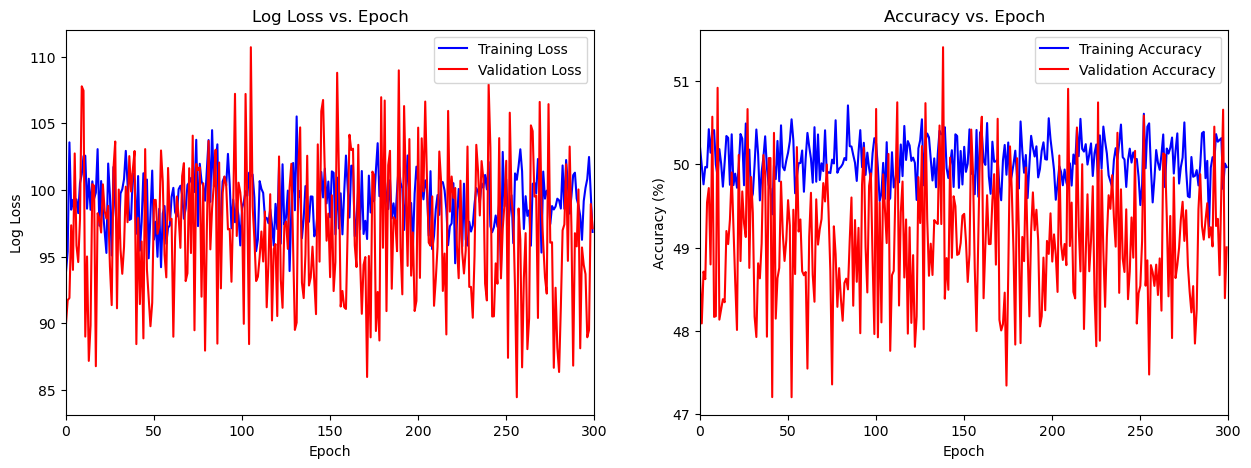

In [14]:
# Plot loss and accuracy
loop.plot()

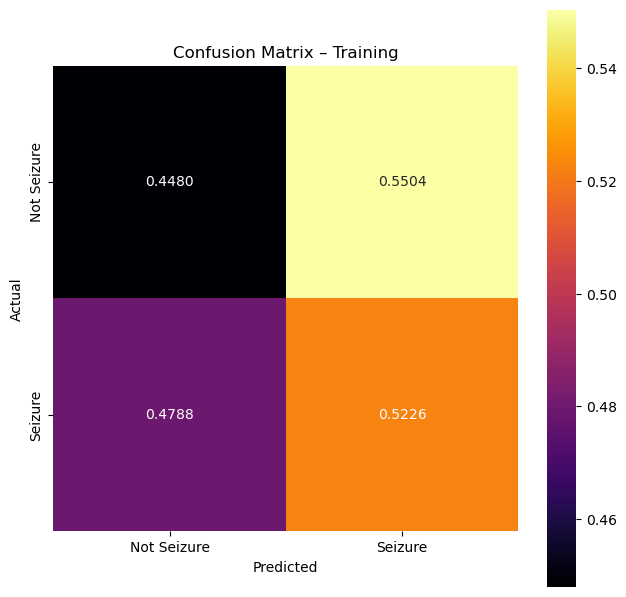

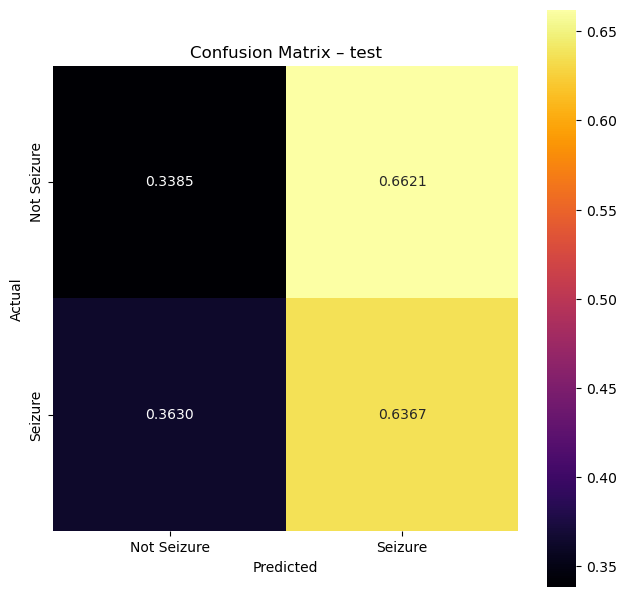

In [15]:
# Create heatmap
y_pred_train = log_reg_model(x_train_norm, train=False)
y_pred_test = log_reg_model(x_test_norm, train=False)

y_class_train = predict(y_pred_train)
y_class_test = predict(y_pred_test)

con_mat_train = confusion(y_pred=y_class_train, y_true=y_train, class_labels=class_labels, title='Training')
con_mat_test = confusion(y_pred=y_class_test, y_true=y_test, class_labels=class_labels, title='test')

In [16]:
TN = con_mat_test[0][0]
TP = con_mat_test[1][1]
FN = con_mat_test[1][0]
FP = con_mat_test[0][1]

recall = TP / (TP + FN) # How many seizures were predicted correctly
precision = TP / (TP + FP) # How many predicted seizures were actually positive
f_score = 2 * (recall * precision) / (recall + precision) # Evaluates whether recall and precision are balanced

print(f"Recall = {recall:.3}\nPrecision = {precision:.3}\nF-Score = {f_score:.3}")

Recall = 0.637
Precision = 0.49
F-Score = 0.554


### Saving Data

In [17]:
export_module = ExportModule(model=log_reg_model, normalizer=x_test_norm, class_pred=predict)
save_path = "output/models/export_module"
tf.saved_model.save(export_module, save_path)


INFO:tensorflow:Assets written to: output/models/export_module/assets


In [18]:
loaded_model = tf.saved_model.load(save_path)
loaded_model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fe8917b5520>